# 4.3 - Transformers




Al igual que sucedía con las [RNN](https://pytorch.org/docs/stable/nn.html#recurrent-layers) (LSTM y GRU) o la Attention, en pytorch también tendremos a nuestra disposición capas ya existentes que nos ayudan a la creación de un [Transformer](https://pytorch.org/docs/stable/nn.html#transformer-layers). 

Estas capas son:

* **`nn.TransformerEncoderLayer`**: Esta capa representa una única capa del encoder de un transformer.
* **`nn.TransformerDecoderLayer`**: Similar a la capa del encoder, esta capa representa una única capa del decoder del transformer.
* **`nn.TransformerEncoder`**: Esta clase agrupa múltiples capas de `nn.TransformerEncoderLayer`, formando el encoder completo del transformer.
* **`nn.TransformerDecoder`**: Esta clase agrupa múltiples capas de `nn.TransformerDecoderLayer`, formando el decoder completo del transformer.

Además, existe una capa que facilita todo el proceso al reunir todas las piezas en una sola estructura:

* **`nn.Transformer`**: Esta clase combina el encoder y el decoder, formando el modelo completo de transformer. 



## 4.3.1 - 🤗 Hugging Face


En esta práctica, al igual que en las anteriores, podríamos crear un **Transformer** para resolver un problema relacionado con secuencias (predecir la siguiente palabra, clasificar textos, ...). 

En vez de realizar esto, vamos a utilizar **modelos ya entrenados** disponibles en [**Hugging Face**](https://huggingface.co/models).

Hugging Face es una comunidad que proporciona acceso a una amplia variedad de modelos. Para utilizarlos en python, simplemente tendremos que instalar la librería `transformers`.

In [ ]:
! pip install transformers

A pesar de su nombre, esta no se limita únicamente a modelos Transformer, la biblioteca también incluye, entre otros:

1. **Modelos de procesamiento de lenguaje natural (NLP)**
2. **Modelos de visión por computador (CV)**
3. **Modelos de multimodalidad**
4. **Modelos de audio**
5. **Otros**

Esta nos permite, además de utilizar modelos pre-entrenados para realizar inferencia, realizar transfer-learning y fine-tunning de estos con el objetivo de adaptarlos mejor a nuestra tarea concreta.

### ¿Cómo utilizar un modelo ya creado?

Para saber como utilizar un modelo dentro de la librería transformers, simplemente tendremos que irnos a la parte superior derecha de su web y hacer click en `Use this model > Transformers`:

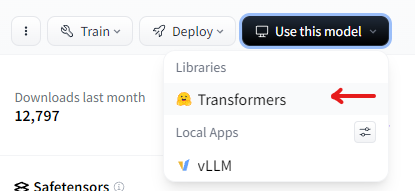

Esto nos indica como cargar el modelo, pero normalmente no detalla como realizar inferencia (probar el modelo). 
Para ello es recomendable acceder a la ayuda de la librería Transformers, buscar la tarea que pretendamos realizar y a la sección de inferencia, por ejemplo, para modelos que resumen texto: https://huggingface.co/docs/transformers/tasks/summarization#inference


Como verás, la librería Transformers de Hugging Face ofrece dos enfoques principales para trabajar con modelos: **pipelines** y **clases específicas** para cada modelo.

Aquí están las diferencias clave entre ambos:

#### *Pipelines*
El uso de pipelines está diseñado para facilitar la vida del usuario. Proporcionan una interfaz de alto nivel que oculta gran parte de la complejidad del modelo subyacente y su preprocesamiento.

A continuación verás como se utiliza un [modelo](https://huggingface.co/timpal0l/mdeberta-v3-base-squad2) entrenado para responder preguntas sobre un texto dado:

```python
from transformers import pipeline

question_answerer = pipeline("question-answering", model="timpal0l/mdeberta-v3-base-squad2")
question_answerer(question=question, context=context)
```

#### *Clases*

Utilizando las clases pertinentes, tendremos más control sobre todos los pasos necesarios para realizar la inferencia, lo que también añade complejidad.

A continuación verás como se utiliza el modelo anterior, pero utilizando las clases pertinentes.

```python
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("timpal0l/mdeberta-v3-base-squad2")
model = AutoModelForQuestionAnswering.from_pretrained("timpal0l/mdeberta-v3-base-squad2")

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)
```

<hr>

A continuación utilizaremos diversos modelos disponibles en la web basados en Transformers para realizar diferentes tareas relacionadas con texto.


### **Ejemplo 1:** Text summarization

En este ejemplo utilizaremos el modelo **BERT2BERT** para resumen de textos en español. Está basado en el modelo BERT (Bidirectional Encoder Representations from Transformers) y se ha afinado específicamente para esta tarea. 

Fue entrenado utilizando el conjunto de datos MLSUM, que incluye más de 1.5 millones de pares de artículos y resúmenes en varios idiomas, incluyendo español. 

Puedes encontrar más información y detalles sobre su uso [aquí](https://huggingface.co/mrm8488/bert2bert_shared-spanish-finetuned-summarization).

In [ ]:
import torch
from transformers import BertTokenizerFast, EncoderDecoderModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Indicamos el checkpoint, que no es más que un identificador del modelo dentro de la web de HugginFace
model_ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'

# Cargamos el tokenizador que nos permitirá introducir y codificar nuestros propios textos
tokenizer = BertTokenizerFast.from_pretrained(model_ckpt)
# Cargamos el modelo
model = EncoderDecoderModel.from_pretrained(model_ckpt).to(device)

In [ ]:
# Para utilizar el modelo, creamos una función (proporcionada en la web del modelo) encargada de tokenizar el texto, introducirlo en el modelo y decodificar el resultado.
def generate_summary(text, min_length=10):
   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model.generate(input_ids, attention_mask=attention_mask, min_length=min_length)
   return tokenizer.decode(output[0], skip_special_tokens=True)

# Texto a analizar
text_1 = "Última lista de admitidos en la Universidad: se confirma el éxito de los dobles grados. Ingeniería Informática del Software y Matemáticas se confirma como la nota de corte más alta. La Universidad de Oviedo ha hecho pública hoy la última lista de adjudicaciones de plazas. La séptima desde el mes de julio. Y aunque, según lo previsto, las notas de corte han ido bajando, lo han hecho muy poco en los grados más demandados. Y los que ocuparon los primeros puestos en el 'ranking' de las notas de corte en la primera lista siguen en las mismas posiciones. Se confirma, por lo tanto, el éxito que los dobles grados tienen entre los universitarios asturianos y, por segundo año consecutivo, se convierten en los títulos con notas más altas de acceso. En cuanto a la nueva oferta de la Universidad de Oviedo, Criminología se ha quedado finalmente en un 11,446; el doble grado de Derecho y Criminología, en 11,305, y Ciencias de la Actividad Física y el Deporte, en 11,130."

# Generamos varios resúmenes indicando un mínimo de longitud deseado.
print(generate_summary(text_1, min_length=30))
print(generate_summary(text_1, min_length=20))
print(generate_summary(text_1, min_length=10))

In [ ]:
# Texto a analizar
text_2 = "Así fue el primer día de universidad de los nuevos alumnos de la Politécnica de Gijón. Con ilusión, nervios y ganas de aprender y hacer nuevos amigos. Así llegaron ayer al Edificio Polivalente de la Escuela Politécnica de Ingeniería (EPI) de Gijón los alrededor de 200 estudiantes de nuevo ingreso que se dieron cita en la primera de las dos jornadas de acogida organizadas por la Universidad de Oviedo. De cara a este curso, cuyas clases arrancarán el próximo 10 de septiembre, la EPI espera a 772 alumnos nuevos. En el anterior fueron 627, lo que supone un crecimiento del 23%. El grado en Ingeniería Mecánica es en el que mayor subida se ha experimentado, de 149 a 214 matriculados. Las encargadas de recibir a los numerosos grupos de jóvenes que acudieron a la EPI fueron la directora, Inés Suárez, y la subdirectora de Estudiantes, María Placeres González. Debido a la gran afluencia, se vieron obligadas a dividir a los estudiantes en dos salas. Suárez hizo hincapié durante su discurso en que “desde hace dos o tres años estamos en una etapa en la que el empleo en Ingeniería está casi garantizado”. “Son estudios que tienen su complejidad, pero con constancia y esfuerzo se sacan adelante. Abren un futuro muy amplio y prometedor”, señaló la directora de la EPI, que resaltó que “se buscan ingenieros en todas partes y aquí tenemos mucha actividad con las empresas”. “Acuden a nosotros y quieren conoceros para que trabajéis con ellos en el futuro”, apuntó Suárez, que puso el foco en que, recientemente, el tejido empresarial asturiano ha cambiado y “hay muchas empresas que se están estableciendo aquí”. “Una de las razones es porque hay una Escuela potente que puede dar talento y que puede servir para que cuando terminéis los estudios os incorporéis a las plantillas”, insistió."

# Generamos varios resúmenes indicando un mínimo de longitud deseado.
print(generate_summary(text_2, min_length=30))
print(generate_summary(text_2, min_length=20))
print(generate_summary(text_2, min_length=10))

### **Ejemplo 2:** Part-Of-Speech tagging

El siguiente modelo utiliza una vez más la arquitectura de **BERT**, pero en este caso ajustada para la tarea de Part-Of-Speech (POS).
El objetivo de esta tarea es, básicamente, identificar la función gramatical de cada una de las palabras de un texto.

En este caso, se ha entrenado para clasificar cada palabra entre 60 etiquetas POS diferentes, entre las que destacan sustantivos, verbos, adjetivos, adverbios, pronombres, preposiciones, conjunciones, y determinantes.

Puedes encontrar más información y detalles sobre su uso [aquí](https://huggingface.co/mrm8488/bert-spanish-cased-finetuned-pos).

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Cargar el tokenizador y el modelo
model_ckpt = "mrm8488/bert-spanish-cased-finetuned-pos"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)
model = AutoModelForTokenClassification.from_pretrained(model_ckpt).to(device)

In [ ]:
# Texto a analizar
text = "Así fue el primer día de universidad de los nuevos alumnos de la Politécnica de Gijón. Con ilusión, nervios y ganas de aprender y hacer nuevos amigos."

# Tokenizar el texto
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)

# Obtener las predicciones del modelo
outputs = model(**inputs)

# Aplicar la "softmax" a los logits del modelo
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

# Convertir las predicciones en una lista de entidades
predicted_entities = predictions[0].numpy()

# Obtener los tokens y sus correspondientes etiquetas
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Crear un diccionario de etiquetas
label_dict = { "AO": "Adjetivo ordinal", "AQ": "Adjetivo calificativo", "CC": "Conjunción de coordinación", "CS": "Conjunción subordinada", "DA": "Determinante artículo", "DD": "Determinante demostrativo", "DE": "Determinante exclamativo", "DI": "Determinante indefinido", "DN": "Determinante numeral", "DP": "Determinante posesivo", "DT": "Determinante interrogativo", "Faa": "Signo de apertura de admiración", "Fat": "Signo de apertura de interrogación", "Fc": "Signo de puntuación: coma", "Fd": "Signo de puntuación: dos puntos", "Fe": "Signo de puntuación: puntos suspensivos", "Fg": "Signo de puntuación: guion", "Fh": "Signo de puntuación: cierre de admiración", "Fia": "Signo de puntuación: apertura de paréntesis", "Fit": "Signo de puntuación: cierre de paréntesis", "Fp": "Signo de puntuación: punto", "Fpa": "Signo de puntuación: apertura de comillas", "Fpt": "Signo de puntuación: cierre de comillas", "Fs": "Signo de puntuación: punto y coma", "Ft": "Signo de puntuación: signo de interrogación", "Fx": "Signo de puntuación: barra", "Fz": "Signo de puntuación: otros", "I": "Interjección", "NC": "Sustantivo común", "NP": "Nombre propio", "P0": "Pronombre personal", "PD": "Pronombre demostrativo", "PI": "Pronombre indefinido", "PN": "Pronombre numeral", "PP": "Pronombre posesivo", "PR": "Pronombre relativo", "PT": "Pronombre interrogativo", "PX": "Pronombre exclamativo", "RG": "Adverbio general", "RN": "Adverbio negativo", "SP": "Preposición", "VAI": "Verbo auxiliar infinitivo", "VAM": "Verbo auxiliar imperativo", "VAN": "Verbo auxiliar indicativo", "VAP": "Verbo auxiliar participio", "VAS": "Verbo auxiliar subjuntivo", "VMG": "Verbo principal gerundio", "VMI": "Verbo principal indicativo", "VMM": "Verbo principal imperativo", "VMN": "Verbo principal infinitivo", "VMP": "Verbo principal participio", "VMS": "Verbo principal subjuntivo", "VSG": "Verbo ser/estar gerundio", "VSI": "Verbo ser/estar indicativo", "VSM": "Verbo ser/estar imperativo", "VSN": "Verbo ser/estar infinitivo", "VSP": "Verbo ser/estar participio", "VSS": "Verbo ser/estar subjuntivo", "Y": "Conjunción", "Z": "Número" }

# Mostrar los resultados
for token, pred in zip(tokens[1:-1], predicted_entities[1:-1]): # El primer y último token se omiten
    pred = list(label_dict.keys())[pred-1]
    entity = label_dict[pred]
    print(f'{token:7s} [{pred}] {entity}')

### **Ejemplo 3:** Detección de idioma

En este último ejemplo, vamos a utilizar el modelo **XLM-RoBERTa** diseñado para la tarea de detección de idiomas.

Fue entrenado en un conjunto de datos que incluye 20 lenguas, logrando una precisión promedio del 99.6% en un conjunto de Test.

Este modelo se utiliza para detectar el idioma en el que se ha escrito un texto, muy util cuando se necesita analizar grandes volúmenes de datos multilingües o cuando se trabaja con aplicaciones que requieren un procesamiento de lenguaje natural en diferentes idiomas.

Puedes encontrar más información y detalles sobre su uso [aquí](https://huggingface.co/papluca/xlm-roberta-base-language-detection).

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Cargar el tokenizador y el modelo
model_ckpt = "papluca/xlm-roberta-base-language-detection"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to(device)

In [ ]:
# Textos a analizar
texts = ["Brevity is the soul of wit.", "Amor, ch'a nullo amato amar perdona.", "Hola, me llamo Jose", "This is a text with two idiomas a la vez, a ver que pasa"]

# Tokenizar el texto
inputs = tokenizer(texts, return_tensors="pt", truncation=True, max_length=512, padding=True)

# Obtener las predicciones del modelo
outputs = model(**inputs)

# Obtener la salida del modelo
logits = outputs.logits
probabilities = torch.softmax(logits, dim=-1)

# Obtener la lista de posibles clases
id2lang = model.config.id2label

# Diccionario de idiomas con códigos como claves
language_dict = { 'ar': 'arabic', 'bg': 'bulgarian', 'de': 'german', 'el': 'modern greek', 'en': 'english', 'es': 'spanish', 'fr': 'french', 'hi': 'hindi', 'it': 'italian', 'ja': 'japanese', 'nl': 'dutch', 'pl': 'polish', 'pt': 'portuguese', 'ru': 'russian', 'sw': 'swahili', 'th': 'thai', 'tr': 'turkish', 'ur': 'urdu', 'vi': 'vietnamese', 'zh': 'chinese' }

for idx, text in enumerate(texts):
    print(f"{text}")
    
    # Obtener las probabilidades y las clases más probables
    top_probs, top_classes = torch.topk(probabilities[idx], 2)

    for i in range(top_classes.size(0)):  # Recorrer las dos clases más probables
        class_label = id2lang[top_classes[i].item()]
        class_prob = top_probs[i].item()
        print(f"  · [{language_dict[class_label].title()}] -> {class_prob*100:.1f} %")


## 4.3.2. - Ejercicios

> **EJERCICIO:** Utiliza el modelo https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-mnli-xnli utilizando pipelines para obtener la compatibilidad de un texto con varias etiquetas posibles (Zero-shot classification).

Utiliza `text_2` e intenta buscar su compatibilidad con las siguientes etiquetas:

```python 
candidate_labels = ["cultura", "sociedad", "economía", "salud", "deportes", "educación"]
```